In [170]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io as sio
import h5py

In [171]:
#%ls ../Team32025/WLI_With_Glass_20251015/ # list data folder/files
#%pwd

In [172]:
def extract_mat_data(folder):
    data_dict = {}

    for filename in os.listdir(folder):
        if filename.endswith('.mat'):
            file_path = os.path.join(folder, filename)
            file_key = os.path.splitext(filename)[0]

            try:
                # Try loading with scipy.io (for most MATLAB files)
                mat_data = sio.loadmat(file_path)
                
                # Filter out MATLAB metadata keys that start with '__'
                clean_data = {k: v for k, v in mat_data.items() if not k.startswith('__')}
                
                data_dict[file_key] = clean_data

            except NotImplementedError:
                # If loadmat fails, it's likely a v7.3 (HDF5-based) file
                with h5py.File(file_path, 'r') as f:
                    h5_data = {}
                    def recursively_load(name, obj):
                        if isinstance(obj, h5py.Dataset):
                            h5_data[name] = np.array(obj)
                    f.visititems(recursively_load)
                    data_dict[file_key] = h5_data

            except Exception as e:
                print(f"Error reading {filename}: {e}")

    return data_dict

In [175]:
path = '/home/james/Desktop/WLI/Team32025/WLI_With_Glass_20251015/'
data = extract_mat_data(path)

#print(data.keys())

## Inspect files
#for key in data.keys():
#    print(f"File: {key}")
#    for var_name, var_data in data[key].items():
#        print(f"  {var_name}: shape {var_data.shape}, dtype {var_data.dtype}")

In [130]:
def extract_data(folder):
    data_dict = {}

    for filename in os.listdir(folder):
        if filename.endswith('.mat'):
            file_path = os.path.join(folder, filename)
            file_key = os.path.splitext(filename)[0]

            try:
                # Try loading with scipy.io (for most MATLAB files)
                mat_data = sio.loadmat(file_path)
                clean_data = {k: v for k, v in mat_data.items() if not k.startswith('__')}

            except NotImplementedError:
                # If it's a v7.3 (HDF5-based) file, use h5py
                with h5py.File(file_path, 'r') as f:
                    clean_data = {}
                    def recursively_load(name, obj):
                        if isinstance(obj, h5py.Dataset):
                            clean_data[name] = np.array(obj)
                    f.visititems(recursively_load)

            # Extract key fields from the structure
            if 'dataArray' in clean_data:
                arr = clean_data['dataArray']
                if arr.ndim == 2 and arr.shape[1] >= 2:
                    HN_data = arr[:, 0]
                    WL_data = arr[:, 1]

                    data_dict[f'{file_key}_HN_data'] = HN_data
                    data_dict[f'{file_key}_WL_data'] = WL_data

            # Optionally store other metadata (if you want)
            meta = {}
            for key in ['runTime', 'xCenCorrection', 'xLinear', 'xLinearStage']:
                if key in clean_data:
                    meta[key] = clean_data[key]
            data_dict[f'{file_key}_meta'] = meta

    return data_dict

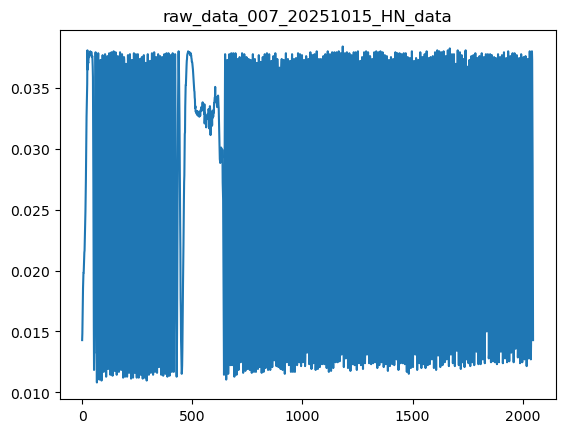

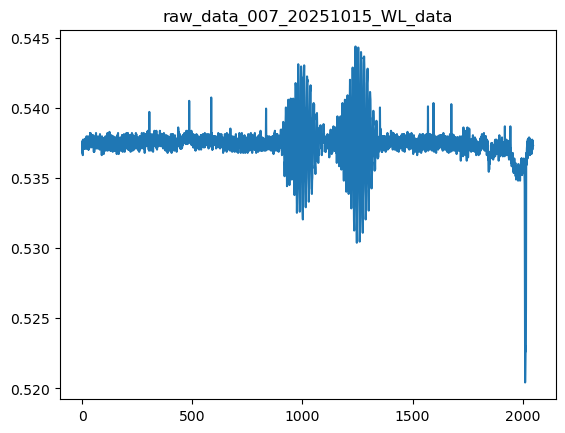

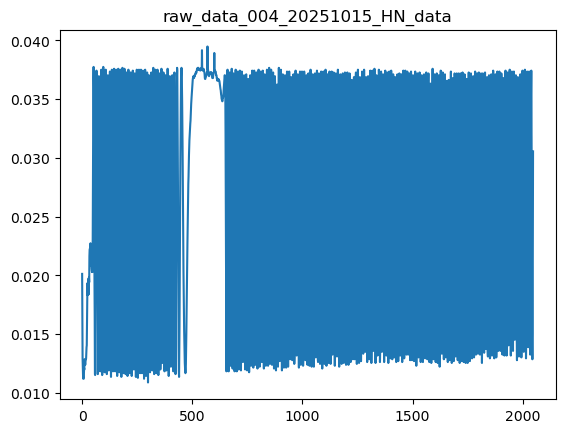

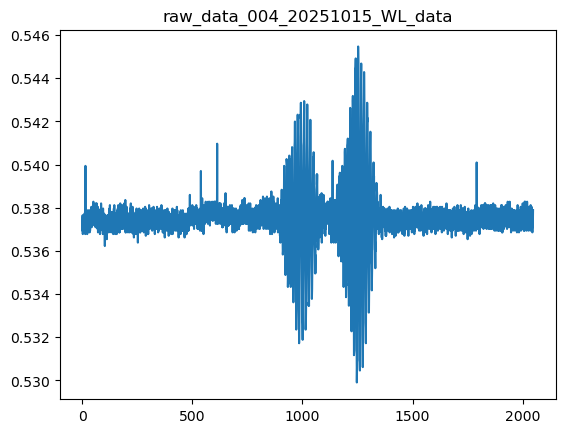

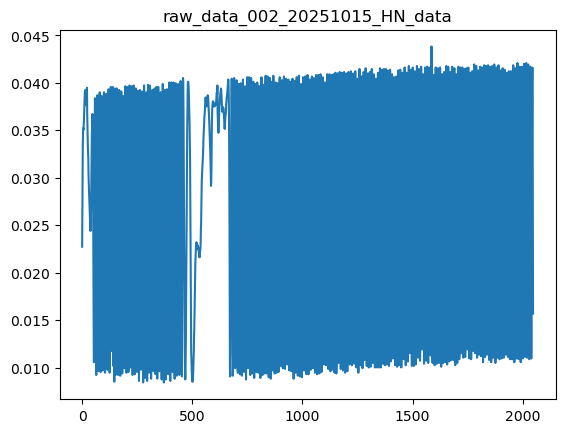

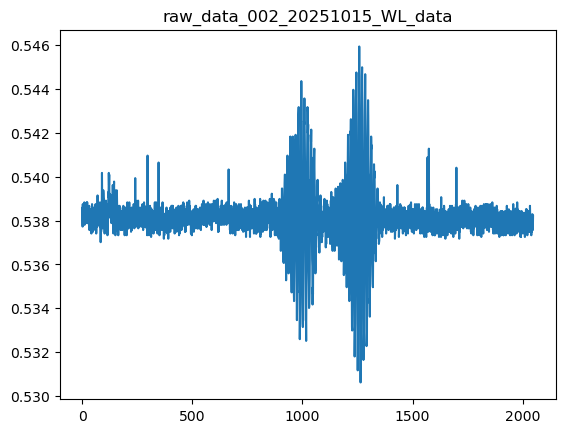

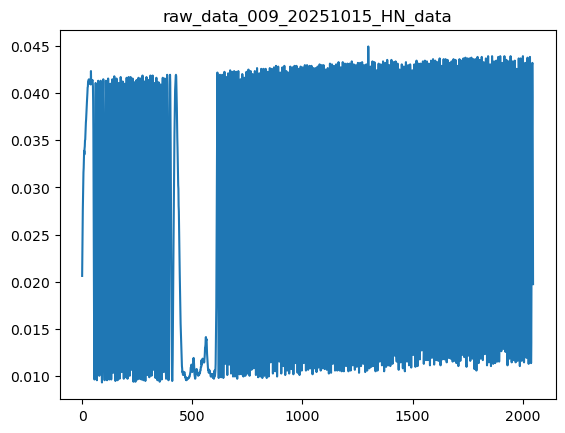

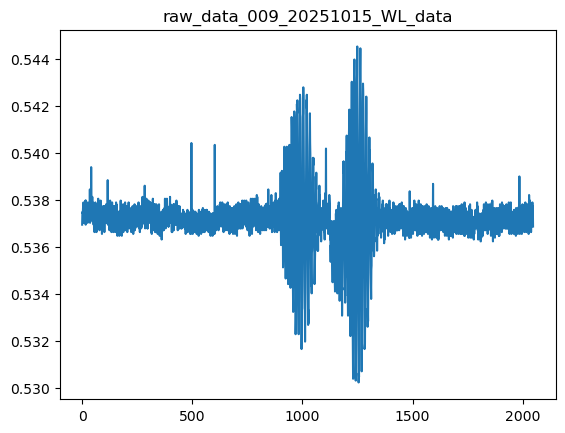

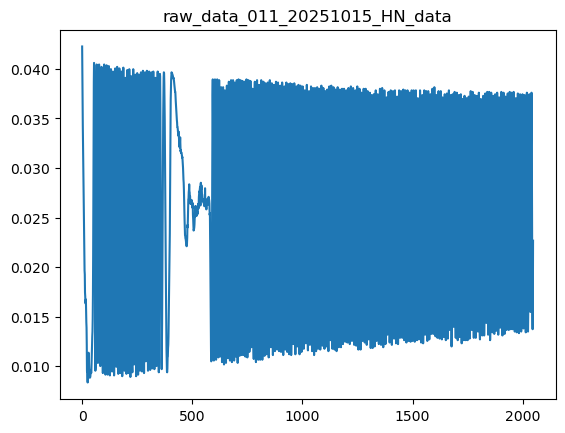

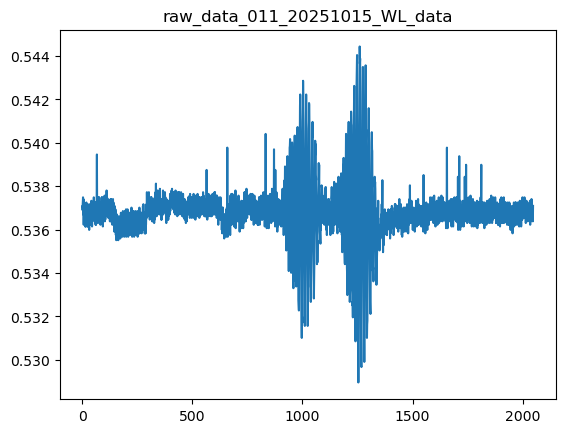

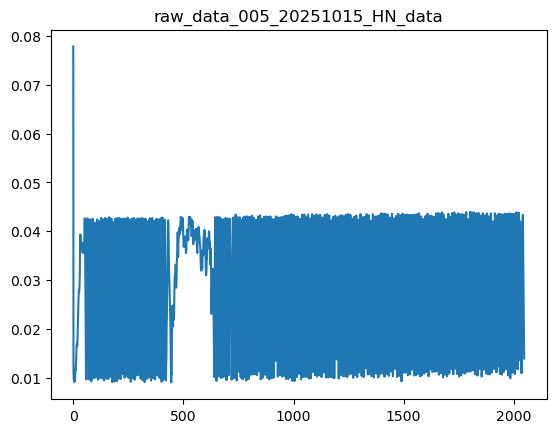

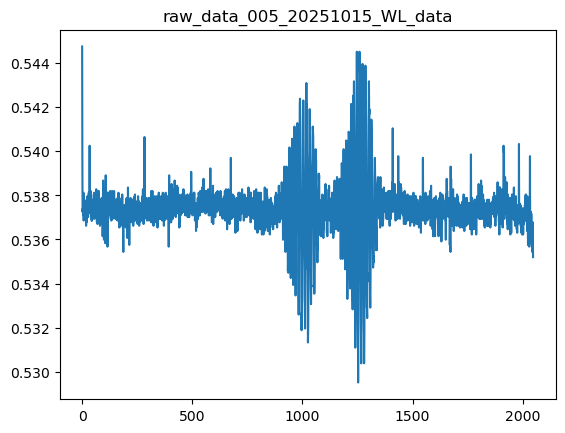

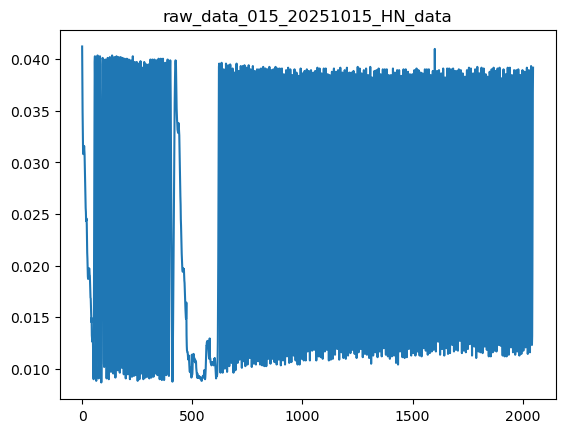

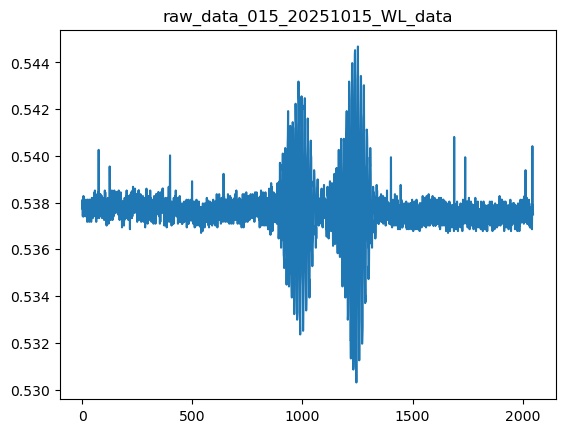

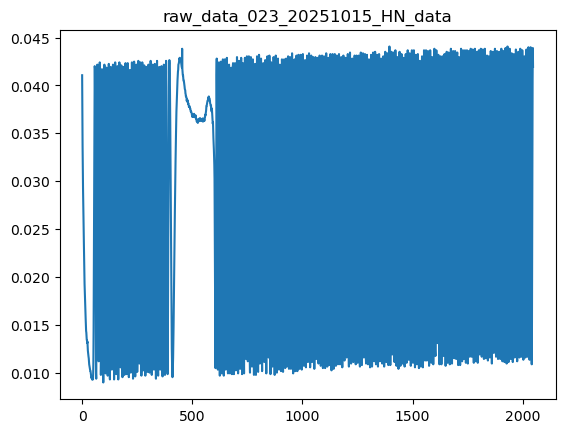

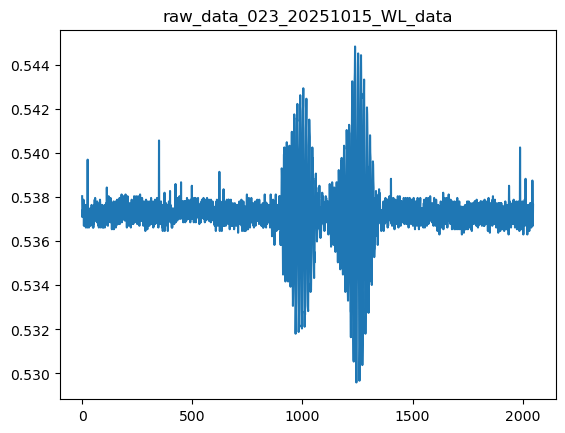

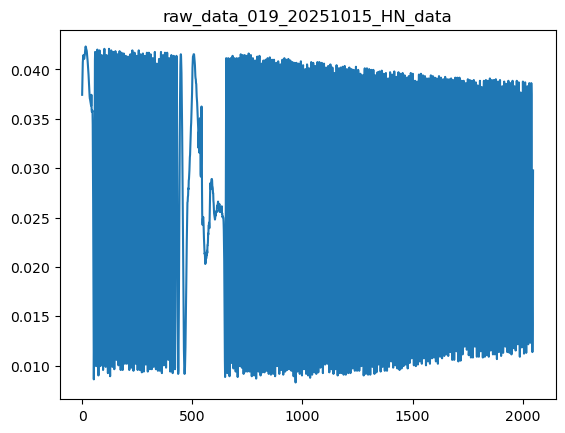

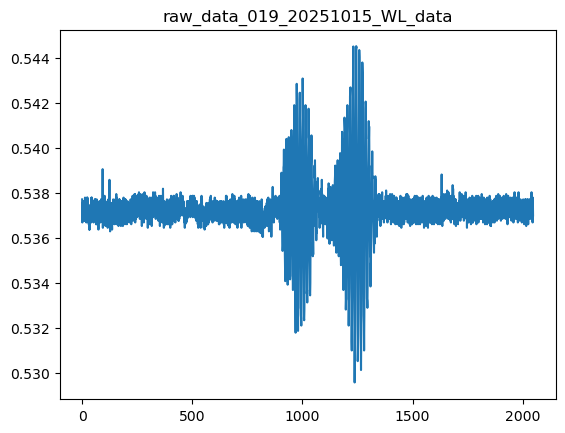

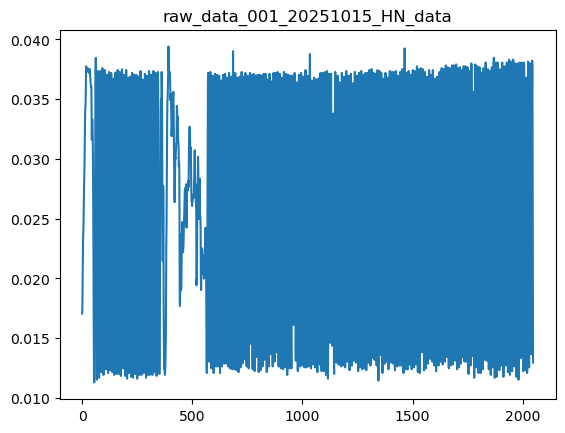

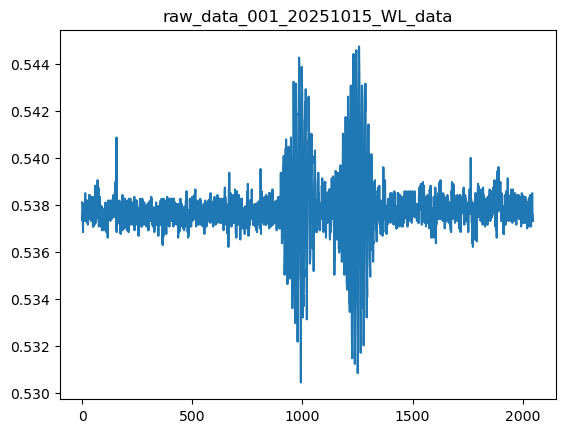

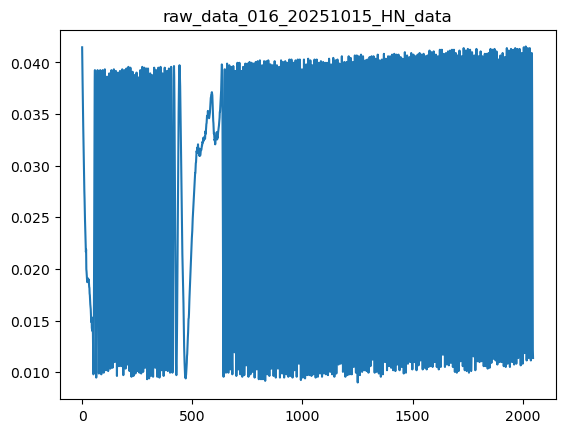

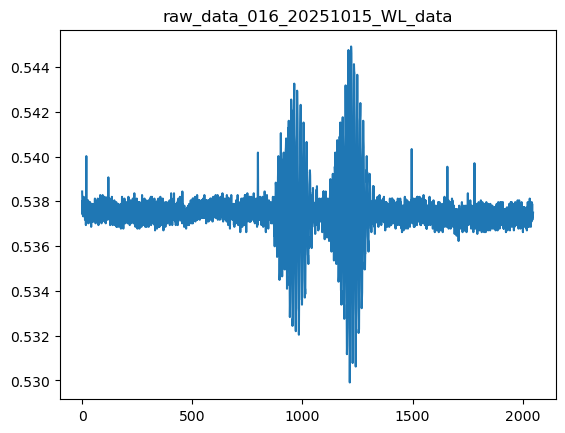

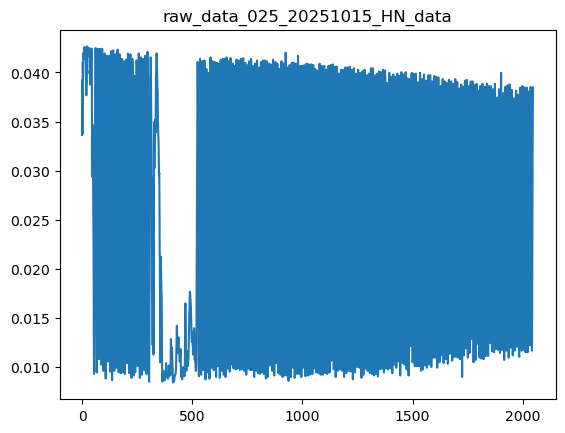

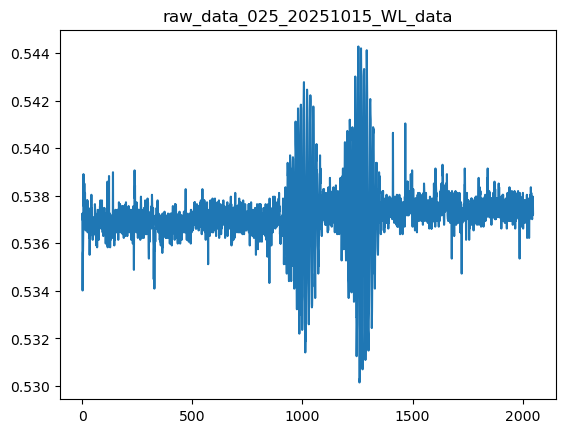

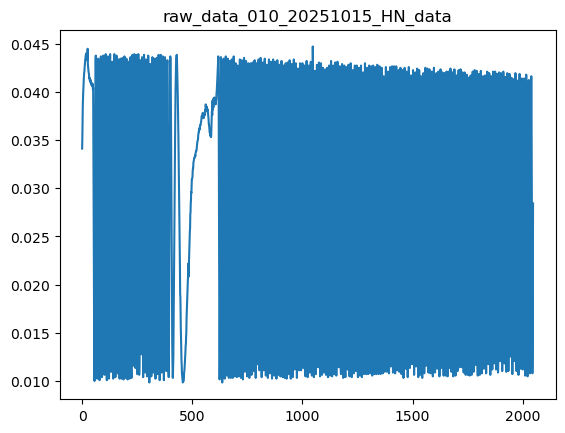

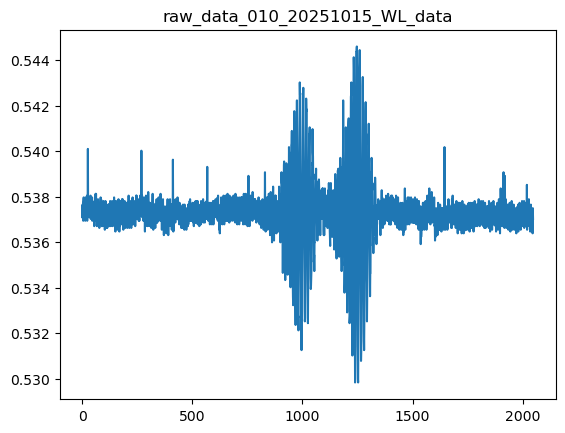

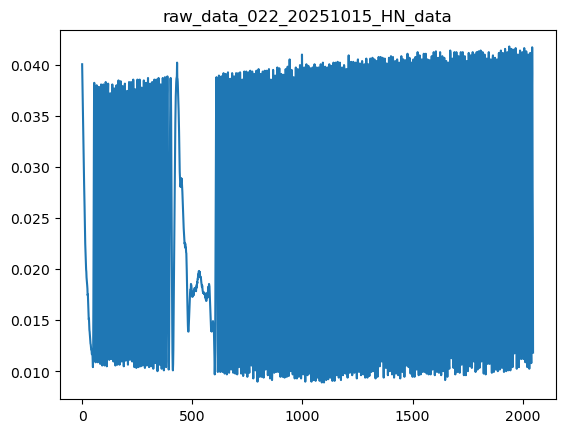

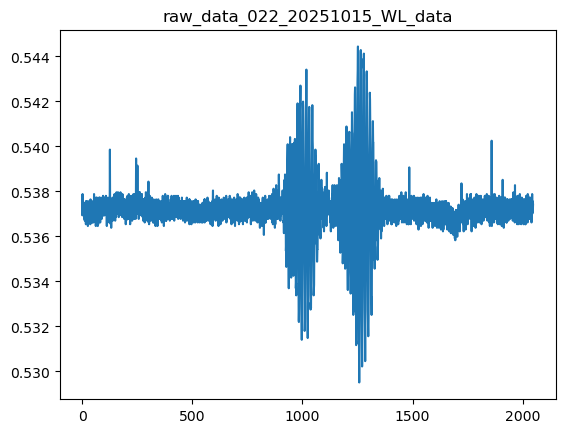

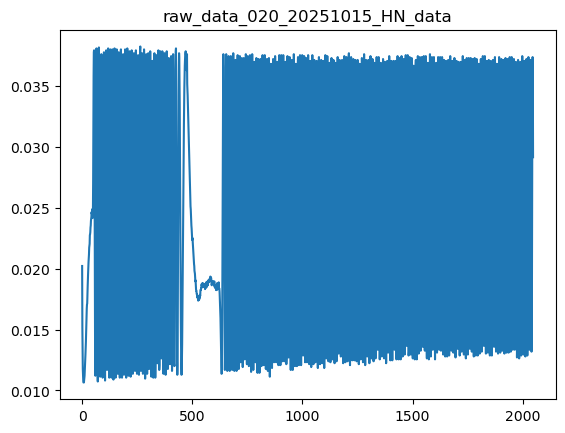

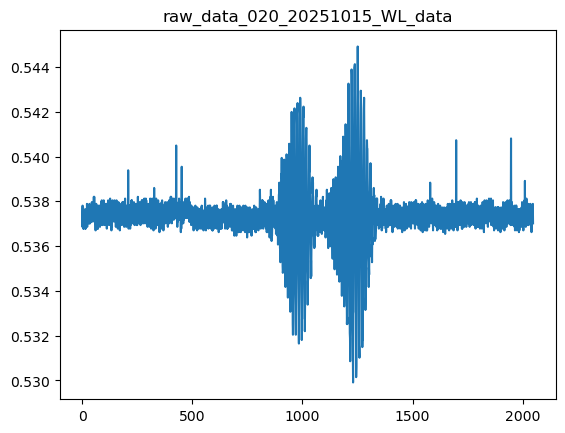

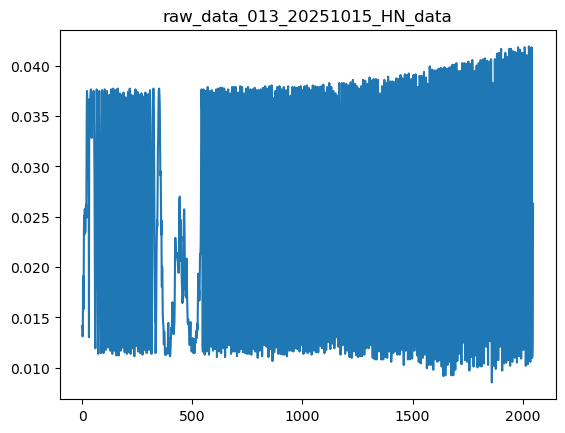

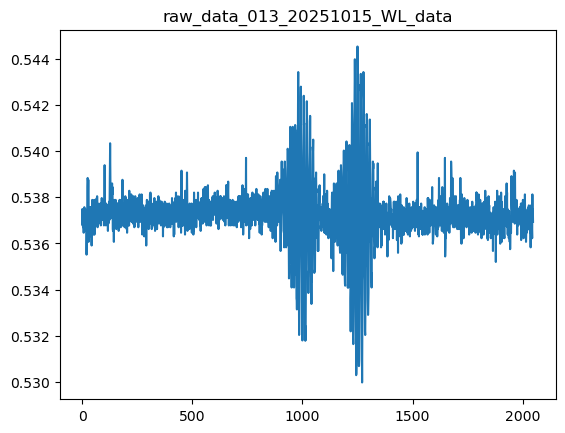

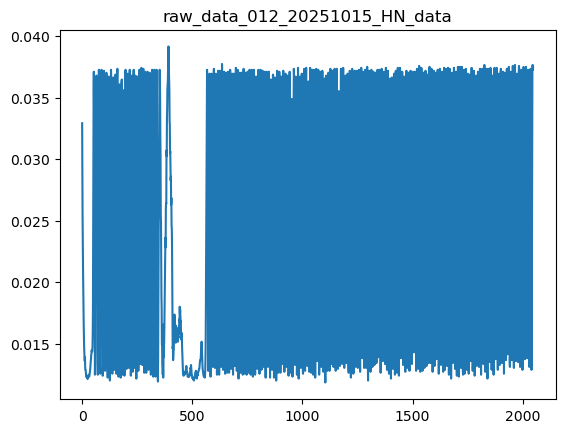

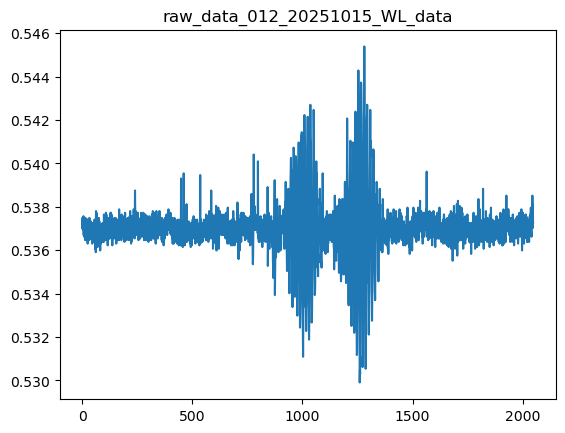

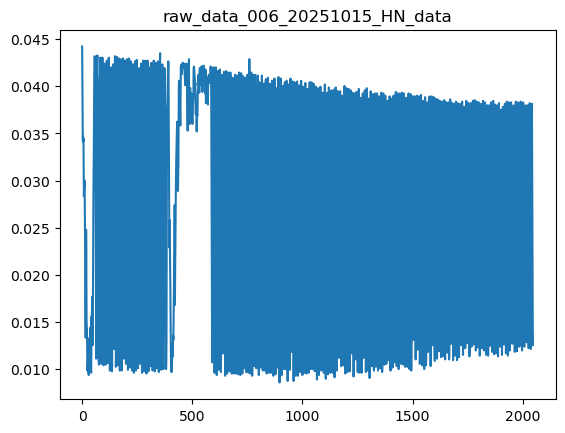

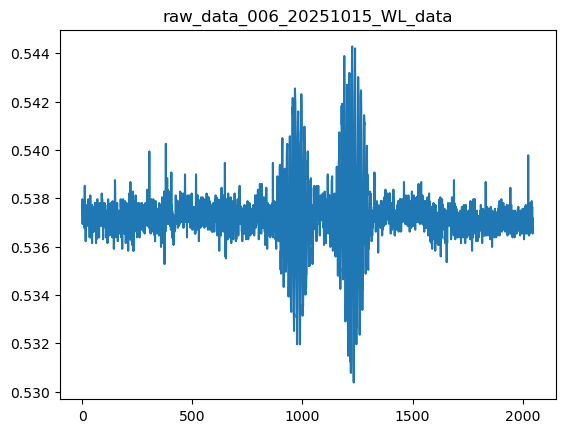

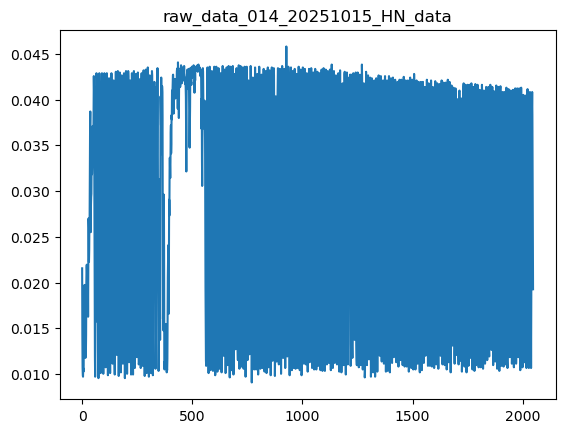

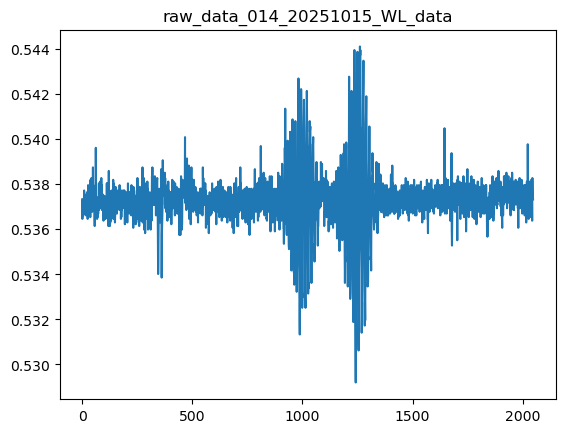

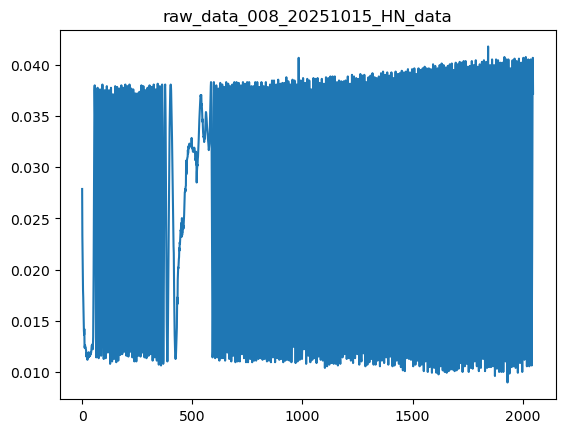

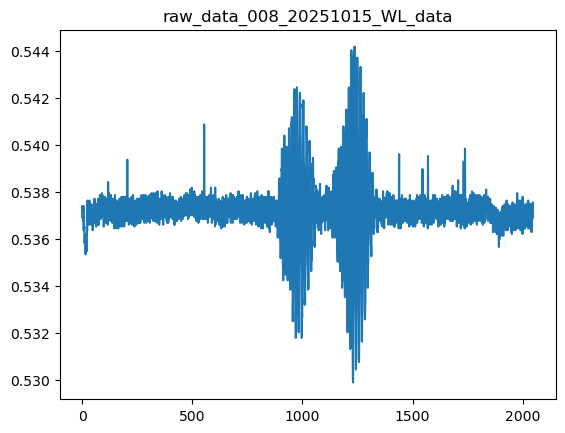

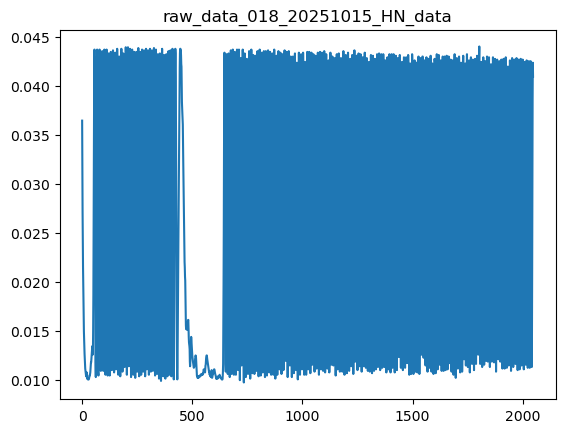

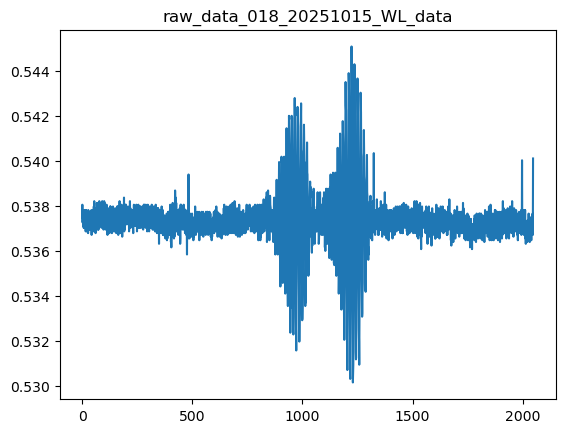

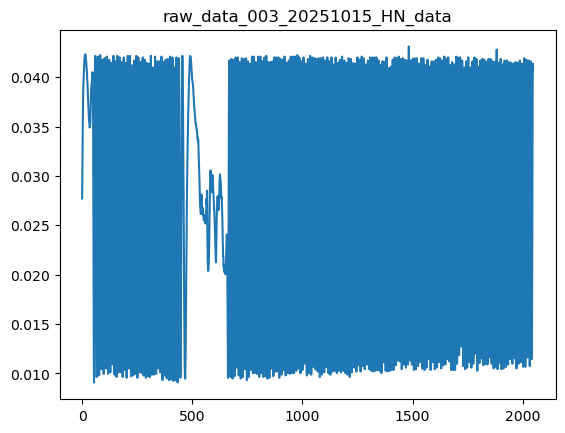

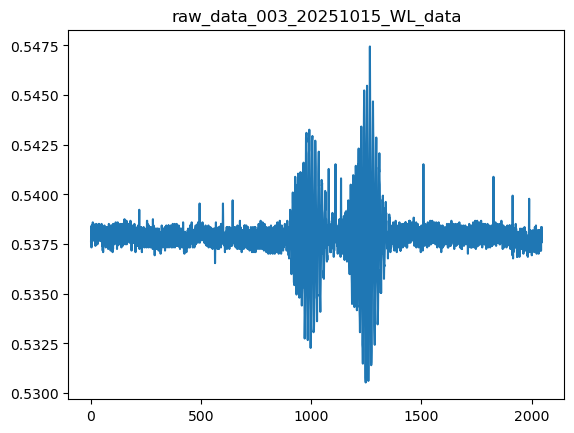

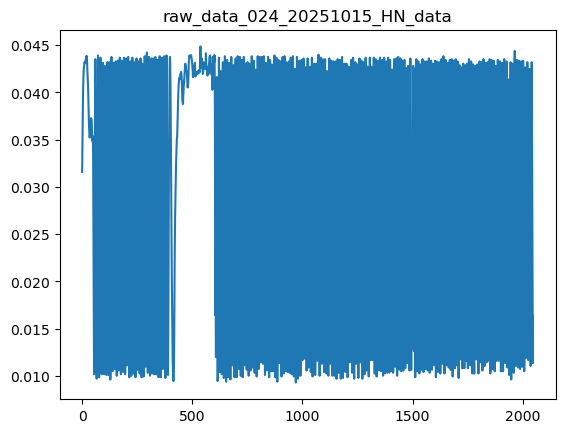

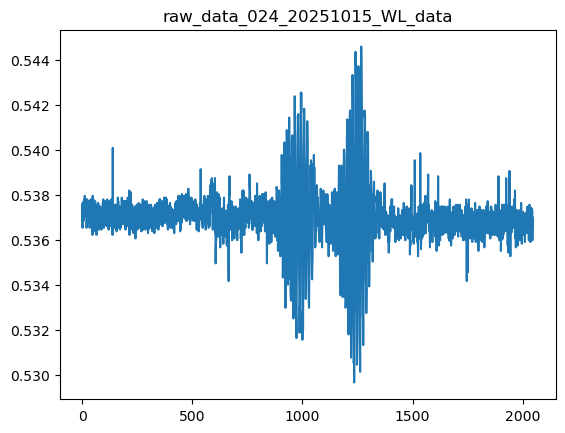

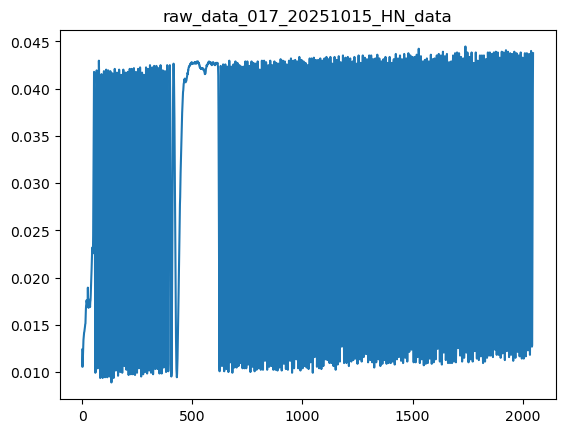

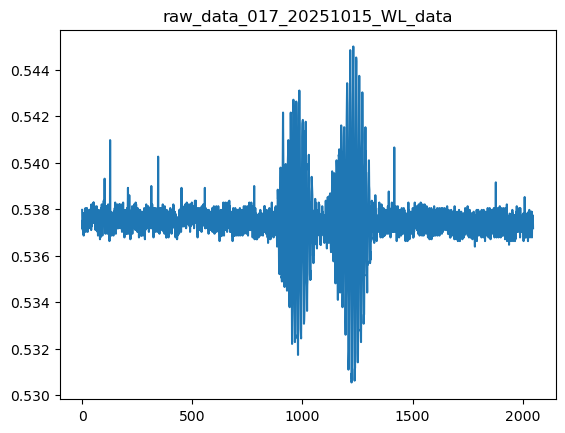

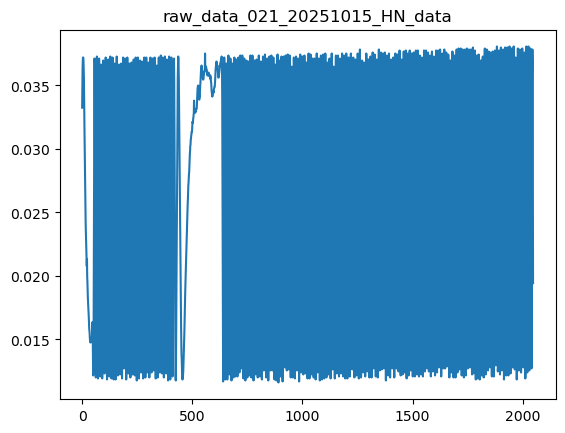

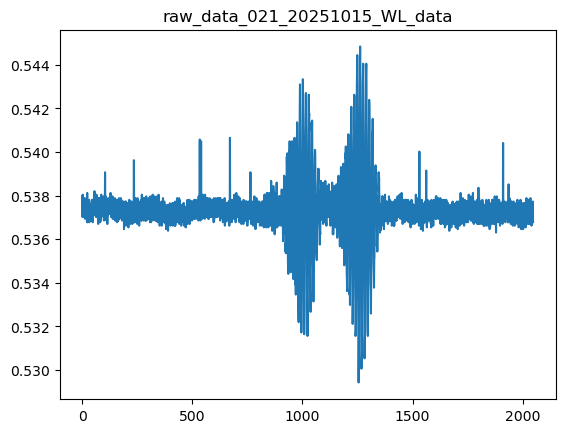

In [179]:
path = '/home/james/Desktop/WLI/Team32025/WLI_With_Glass_20251015/'
data = extract_data(path)

#print(data.keys())
data2plot = []
for key in data.keys():
    if key.endswith('_HN_data') or key.endswith('_WL_data'):
        data2plot.append(key)

#fig, axes = plt.subplot(len(data2plot),1, figsize=(6,4))
for dataname in data2plot:
    plt.plot(data[dataname])
    plt.title(dataname)
    plt.show()
    #print(data[dataname])

In [156]:
#raw_data_007_20251015_HN_data
#raw_data_007_20251015_WL_data
data1HN = data['raw_data_007_20251015_HN_data']
data1WL = data['raw_data_007_20251015_WL_data']
metadata = data['raw_data_007_20251015_meta']
print(metadata.keys())  # -> dict_keys(['runTime', 'xCenCorrection', ...])

dict_keys(['runTime', 'xCenCorrection', 'xLinear', 'xLinearStage'])


In [153]:
data1HN
data1WL

array([0.53725311, 0.53677912, 0.53764811, ..., 0.53764811, 0.53741111,
       0.53733211])

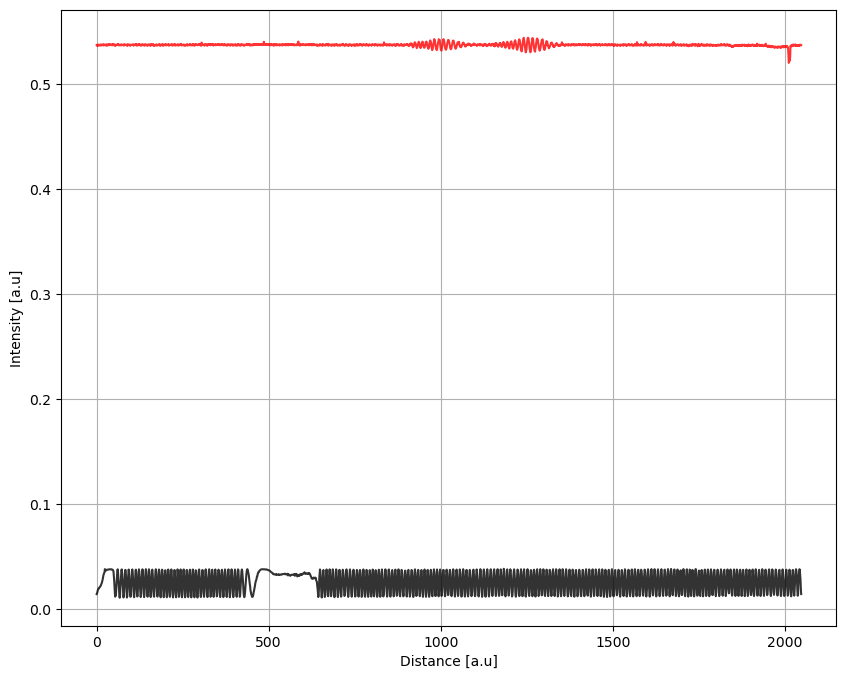

In [151]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

ax.plot(data1HN, color='k', alpha=0.8) # first column is HeNe
ax.plot(data1WL, color='r', alpha=0.8) # second column is WL
ax.set_xlabel('Distance [a.u]')
ax.set_ylabel('Intensity [a.u]')
ax.grid(True)

#ax[1].plot(data1xLin[0,:], data1xLinStage[:,0], color='k')

plt.show()